In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub


In [2]:
cols = ['country', 'description', 'points', 'price', 'variety', 'winery']
df = pd.read_csv("D:\Data Science and Big Data\\fcc-Tensorflow\datasets\wine-reviews.csv",usecols= cols)
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [3]:
df.shape
df = df.dropna(subset=["description", "points"])

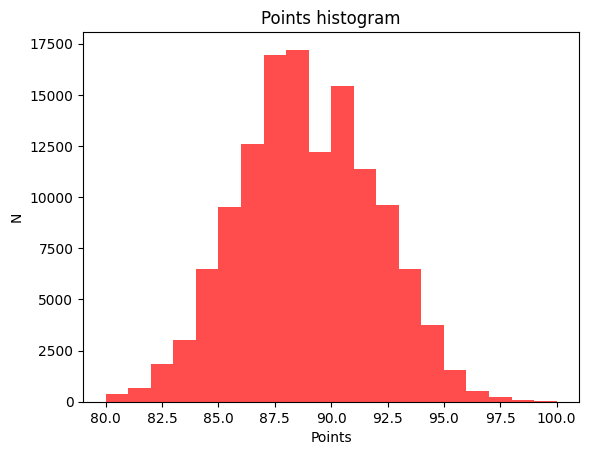

In [4]:
plt.hist(df.points, bins=20,alpha = 0.7, color= 'red')
plt.title('Points histogram')
plt.xlabel('Points')
plt.ylabel('N')
plt.show()

In [5]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description","label"]]

In [6]:
train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)), int(0.9*len(df))])

In [7]:
len(train), len(val) , len(test)

(103976, 12997, 12998)

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [9]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# Embedding + Model

In [11]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype= tf.string, trainable=True)

In [12]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.15618245,  0.0853972 ,  0.17866558, ..., -0.05407052,
        -0.13538487, -0.03081194],
       [ 0.12835513, -0.522063  , -0.13907562, ..., -0.11004329,
         0.07994922,  0.15945907],
       [ 0.21459323, -0.15536293,  0.11727832, ..., -0.099712  ,
        -0.00878691,  0.01374052],
       ...,
       [ 0.4567694 , -0.18231267,  0.02693305, ..., -0.05754515,
        -0.30091426, -0.17330195],
       [ 0.2496795 , -0.10114406,  0.02802086, ...,  0.08703652,
        -0.3177799 ,  0.0502725 ],
       [ 0.41551602, -0.30342174,  0.0813344 , ..., -0.06868894,
         0.18063667,  0.05096305]], dtype=float32)>

In [19]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics= ['accuracy']
              )

In [21]:
model.evaluate(train_data)

102/102 [==============================] - 5s 49ms/step - loss: 0.7058 - accuracy: 0.3849


[0.7057563066482544, 0.384906142950058]

In [22]:
history = model.fit(train_data,epochs=5,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 41s 391ms/step - loss: 0.5629 - accuracy: 0.7079 - val_loss: 0.4142 - val_accuracy: 0.8156
Epoch 2/5
102/102 [==============================] - 42s 414ms/step - loss: 0.4089 - accuracy: 0.8267 - val_loss: 0.3879 - val_accuracy: 0.8247
Epoch 3/5
102/102 [==============================] - 48s 469ms/step - loss: 0.3735 - accuracy: 0.8442 - val_loss: 0.3828 - val_accuracy: 0.8260
Epoch 4/5
102/102 [==============================] - 51s 500ms/step - loss: 0.3523 - accuracy: 0.8569 - val_loss: 0.3795 - val_accuracy: 0.8295
Epoch 5/5
102/102 [==============================] - 59s 572ms/step - loss: 0.3341 - accuracy: 0.8645 - val_loss: 0.3860 - val_accuracy: 0.8301


In [23]:
model.evaluate(test_data)

13/13 [==============================] - 1s 74ms/step - loss: 0.3737 - accuracy: 0.8317


[0.37365299463272095, 0.8316664099693298]